In [122]:
from __future__ import annotations

import json
import hashlib
from pathlib import Path
from copy import deepcopy


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
)

import joblib

# Größen in cm → umrechnen in inches
cm = 1/2.54



# marker und dicken von linien und der achsen und alles sollte einheitlich sein
plt.rcParams.update({
    "figure.figsize": (18*cm, 8*cm),   # default: 18×8 cm
    "font.size": 10,                    # Standardschriftgröße
    "axes.titlesize": 10,
    "axes.labelsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "figure.dpi": 300, # für saubere Notebooks/Export
    "lines.linewidth": 1.0,
    "lines.markersize": 4,
    "axes.linewidth": 1.0,
    "xtick.major.width": 1.0,
    "ytick.major.width": 1.0,
    "xtick.minor.width": 1.0,
    "ytick.minor.width": 1.0,
})

EXPERIMENTS_DIR = Path("experiments/LinSVM")

METRICS_PATH = EXPERIMENTS_DIR / "metrics_long.csv"   # long format: (experiment_id x class)
RUNS_PATH    = EXPERIMENTS_DIR / "runs_global.csv"    # one row per experiment run

In [ ]:
def load_or_empty_csv(path, columns):
    if path.exists():
        return pd.read_csv(path)
    return pd.DataFrame(columns=columns)


def append_and_dedup(df_old, df_new, subset):
    out = pd.concat([df_old, df_new], ignore_index=True)
    out = out.drop_duplicates(subset=subset, keep="last")
    return out


def save_confusion_matrices(experiment_id, cm_raw, cm_norm):
    out_dir = EXPERIMENTS_DIR / experiment_id
    out_dir.mkdir(parents=True, exist_ok=True)
    np.save(out_dir / "confusion_raw.npy", cm_raw)
    np.save(out_dir / "confusion_norm.npy", cm_norm)
    

def log_run_global(experiment_id, cfg, global_metrics):
    cols = ["experiment_id", "config_json", "accuracy", "macro_f1", "weighted_f1"]
    df_old = load_or_empty_csv(RUNS_PATH, cols)

    row = {
        "experiment_id": experiment_id,
        "config_json": json.dumps(cfg, sort_keys=True),
        **global_metrics,
    }
    df_new = pd.DataFrame([row], columns=cols)
    df_out = append_and_dedup(df_old, df_new, subset=["experiment_id"])
    df_out.to_csv(RUNS_PATH, index=False)

def log_metrics_long(experiment_id, cfg, report_dict, train_counts):
    # Minimal per-class columns that are always meaningful
    base_cols = [
        "experiment_id", "class_id",
        "precision", "recall", "f1", "support_val",
        "n_train_class",
        "config_json",
    ]

    # Optional "nice-to-have" columns (only filled if present)
    optional_cols = [
        "vectorizer",
        "model",
        "class_weight",
        "analyzer", "ngram_min", "ngram_max", "max_features",   # single-vectorizer case
        "word_ngram_min", "word_ngram_max", "word_max_features", "word_min_df",
        "char_ngram_min", "char_ngram_max", "char_max_features", "char_min_df",
    ]

    cols = base_cols + optional_cols

    df_old = load_or_empty_csv(METRICS_PATH, cols)

    rows = []
    cfg_json = json.dumps(cfg, sort_keys=True)

    for k, v in report_dict.items():
        if k in ("accuracy", "macro avg", "weighted avg"):
            continue

        class_id = int(k)
        print(f"Logging metrics for class_id: {class_id}")

        row = {
            "experiment_id": experiment_id,
            "class_id": class_id,
            "precision": float(v["precision"]),
            "recall": float(v["recall"]),
            "f1": float(v["f1-score"]),
            "support_val": int(v["support"]),
            "n_train_class": int(train_counts.get(str(class_id), 0)),
            "config_json": cfg_json,
        }

        # Fill optional keys if they exist; otherwise leave blank/NaN
        for key in optional_cols:
            if key in cfg:
                row[key] = cfg[key]

        rows.append(row)

    df_new = pd.DataFrame(rows, columns=cols)

    # If old file has fewer columns (from earlier runs), align columns before concat
    for c in df_old.columns:
        if c not in df_new.columns:
            df_new[c] = np.nan
    for c in df_new.columns:
        if c not in df_old.columns:
            df_old[c] = np.nan

    df_new = df_new[df_old.columns]  # same order
    df_out = append_and_dedup(df_old, df_new, subset=["experiment_id", "class_id"])
    df_out.to_csv(METRICS_PATH, index=False)

In [124]:
# splitting is already done
TEXT_VARIANT_COL  = "text_stripped"   # from your current notebook
LABEL_COL = "prdtypecode"

# train df
DATA_DIR = Path("data")
DATA_PATH_train = DATA_DIR / "train.csv"

train_df = pd.read_csv(DATA_PATH_train)
# val df
DATA_PATH_val = DATA_DIR / "test.csv"
val_df = pd.read_csv(DATA_PATH_val)

#### LabelEncoder ###
##############################################

# print shapes
print(f"Train shape: {train_df.shape}")
print(f"Validation shape: {val_df.shape}")

X_train = train_df[TEXT_VARIANT_COL].astype(str)
y_train = train_df[LABEL_COL].astype(str)

    # validation data
X_val = val_df[TEXT_VARIANT_COL].astype(str)
y_val = val_df[LABEL_COL].astype(str)

train_counts = pd.Series(y_train).value_counts().sort_index()
val_counts   = pd.Series(y_val).value_counts().sort_index()
print(train_counts)

Train shape: (66800, 6)
Validation shape: (16701, 6)
prdtypecode
10      2491
1140    2136
1160    3162
1180     611
1280    3878
1281    1632
1300    4005
1301     555
1302    1900
1320    2578
1560    4006
1920    3268
1940     642
2060    3887
2220     658
2280    3808
2403    3810
2462    1126
2522    3959
2582    2006
2583    7850
2585    1970
2705    2207
2905     698
40      1987
50      1316
60       654
Name: count, dtype: int64


In [125]:
train_counts = pd.Series(y_train).value_counts().to_dict()
print(train_counts)

{'2583': 7850, '1560': 4006, '1300': 4005, '2522': 3959, '2060': 3887, '1280': 3878, '2403': 3810, '2280': 3808, '1920': 3268, '1160': 3162, '1320': 2578, '10': 2491, '2705': 2207, '1140': 2136, '2582': 2006, '40': 1987, '2585': 1970, '1302': 1900, '1281': 1632, '50': 1316, '2462': 1126, '2905': 698, '2220': 658, '60': 654, '1940': 642, '1180': 611, '1301': 555}


In [126]:
# Predictions
# import clf from saved model using joblib

# 


PATH = "experiments/LinSVM/"

# go over all experiment ids in experiments dir
experiment_ids = [d.name for d in EXPERIMENTS_DIR.iterdir() if d.is_dir()]

for experiment_id in experiment_ids:
    
    # check if evaluation already done by checking in the runs_global.csv
    runs_df = load_or_empty_csv(RUNS_PATH, ["experiment_id"])
    if experiment_id in runs_df["experiment_id"].values:
        print(f"Experiment {experiment_id} already evaluated. Skipping.")
        continue
    
    
    clf = joblib.load(f"{PATH}{experiment_id}/model.joblib")
    CFG = joblib.load(f"{PATH}{experiment_id}/config.joblib")
    X_val_vec = joblib.load(f"{PATH}{experiment_id}/X_val_vec.joblib")
    y_val = joblib.load(f"{PATH}{experiment_id}/y_val.joblib")

    # vocab_size = len(vec.vocabulary_)
    # print(f"\nExperiment {experiment_id} | run_name={CFG.get('run_name')}")
    # print(
    #     f"Vectorizer: analyzer={vec.analyzer}, "
    #     f"ngram_range={vec.ngram_range}, "
    #     f"max_features={vec.max_features}, "
    #     f"vocab_size={vocab_size}, "
    #     f"X_val_shape={X_val_vec.shape}, "
    #     f"X_val_nnz={X_val_vec.nnz}"
    # )


    y_pred = clf.predict(X_val_vec)

    # Global metrics
    acc = accuracy_score(y_val, y_pred)
    macro_f1 = f1_score(y_val, y_pred, average="macro")
    weighted_f1 = f1_score(y_val, y_pred, average="weighted")

    global_metrics = {
        "accuracy": float(acc),
        "macro_f1": float(macro_f1),
        "weighted_f1": float(weighted_f1),
    }

    # print("Global metrics:")
    # print(global_metrics)

    # Per-class report (dict + pretty print)
    report = classification_report(y_val, y_pred, output_dict=True, zero_division=0)
    # print("\nClassification report (text):")
    # print(classification_report(y_val, y_pred, zero_division=0))

    # Confusion matrices
    labels_sorted = np.sort(np.unique(y_val))
    cm_raw = confusion_matrix(y_val, y_pred, labels=labels_sorted)
    cm_norm = confusion_matrix(y_val, y_pred, labels=labels_sorted, normalize="true")
    train_counts = pd.Series(y_train).value_counts().to_dict()
    # save_everything
    log_run_global(experiment_id, CFG, global_metrics)
    log_metrics_long(experiment_id, CFG, report, train_counts)
    save_confusion_matrices(experiment_id, cm_raw, cm_norm)

    print("\nSaved:")
    print(" - global runs:", RUNS_PATH)
    print(" - per-class metrics:", METRICS_PATH)
    print(" - confusion matrices dir:", (EXPERIMENTS_DIR / experiment_id))


C:\Users\Taoufiq\AppData\Local\Temp\ipykernel_43168\2860735336.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  out = pd.concat([df_old, df_new], ignore_index=True)
C:\Users\Taoufiq\AppData\Local\Temp\ipykernel_43168\2860735336.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  out = pd.concat([df_old, df_new], ignore_index=True)


Logging metrics for class_id: 10
Logging metrics for class_id: 1140
Logging metrics for class_id: 1160
Logging metrics for class_id: 1180
Logging metrics for class_id: 1280
Logging metrics for class_id: 1281
Logging metrics for class_id: 1300
Logging metrics for class_id: 1301
Logging metrics for class_id: 1302
Logging metrics for class_id: 1320
Logging metrics for class_id: 1560
Logging metrics for class_id: 1920
Logging metrics for class_id: 1940
Logging metrics for class_id: 2060
Logging metrics for class_id: 2220
Logging metrics for class_id: 2280
Logging metrics for class_id: 2403
Logging metrics for class_id: 2462
Logging metrics for class_id: 2522
Logging metrics for class_id: 2582
Logging metrics for class_id: 2583
Logging metrics for class_id: 2585
Logging metrics for class_id: 2705
Logging metrics for class_id: 2905
Logging metrics for class_id: 40
Logging metrics for class_id: 50
Logging metrics for class_id: 60

Saved:
 - global runs: experiments\LinSVM\runs_global.csv
 - p

In [169]:
dfm = pd.read_csv(METRICS_PATH)

def plot_f1_vs_class_and_ntrain(experiment_ids, xtick_step=500, n_label_worst=5, savepath=None):
    
    d = dfm[dfm["experiment_id"].isin(experiment_ids)].copy()
    if d.empty:
        raise ValueError("No rows found for the given experiment_ids.")

    # reference experiment (defines ordering + worst classes)
    ref = (
        d[d["experiment_id"] == experiment_ids[0]]
        .loc[:, ["class_id", "n_train_class", "f1"]]
        .drop_duplicates()
        .sort_values("n_train_class")
        .reset_index(drop=True)
    )

    x_vals = ref["n_train_class"].values
    class_labels = ref["class_id"].astype(str).values
    # identify worst classes by F1
    worst_classes = (
        ref.sort_values("f1", ascending=True)
           .head(n_label_worst)["class_id"]
           .astype(str)
           .tolist()
    )
    
    print("Worst classes (by F1):", worst_classes)

    fig, ax = plt.subplots(figsize=(18*cm, 10*cm))

    # plot experiments
    for exp_id in experiment_ids:
        di = (
            d[d["experiment_id"] == exp_id]
            .loc[:, ["class_id", "f1"]]
            .drop_duplicates()
            .merge(ref[["class_id", "n_train_class"]], on="class_id", how="inner")
            .sort_values("n_train_class")
        )

        ax.scatter(
            di["n_train_class"].values,
            di["f1"].values,
            s=25,
            label=exp_id,
        )

    # bottom axis (numeric)
    ax.set_xlabel("number of training samples per class")
    ax.set_ylabel("F1 score (per class)")
    ax.set_ylim(0, 1.1)

    xmin, xmax = x_vals.min(), x_vals.max()
    xticks = np.arange(
        (xmin // xtick_step) * xtick_step,
        xmax + xtick_step,
        xtick_step,
    )
    ax.set_xticks(xticks)
    ax.grid(True, alpha=0.3)

    # top axis: label ONLY worst classes
    ax_top = ax.twiny()
    ax_top.set_xlim(ax.get_xlim())
    ax_top.set_xticks(x_vals)

    top_labels = [
        lbl if lbl in worst_classes else ""
        for lbl in class_labels
    ]
    ax_top.set_xticklabels(top_labels, rotation=90)
    ax_top.set_xlabel(f"prdtypecode (lowest {n_label_worst} F1 only shown)")

    print(n_label_worst)
    
    ax.legend()
    # ax.legend(fontsize=8)
    plt.tight_layout()

    if savepath:
        plt.savefig(savepath, dpi=200, bbox_inches="tight")

    plt.show()


Worst classes (by F1): ['10', '1281', '1180', '1280', '2705']
5


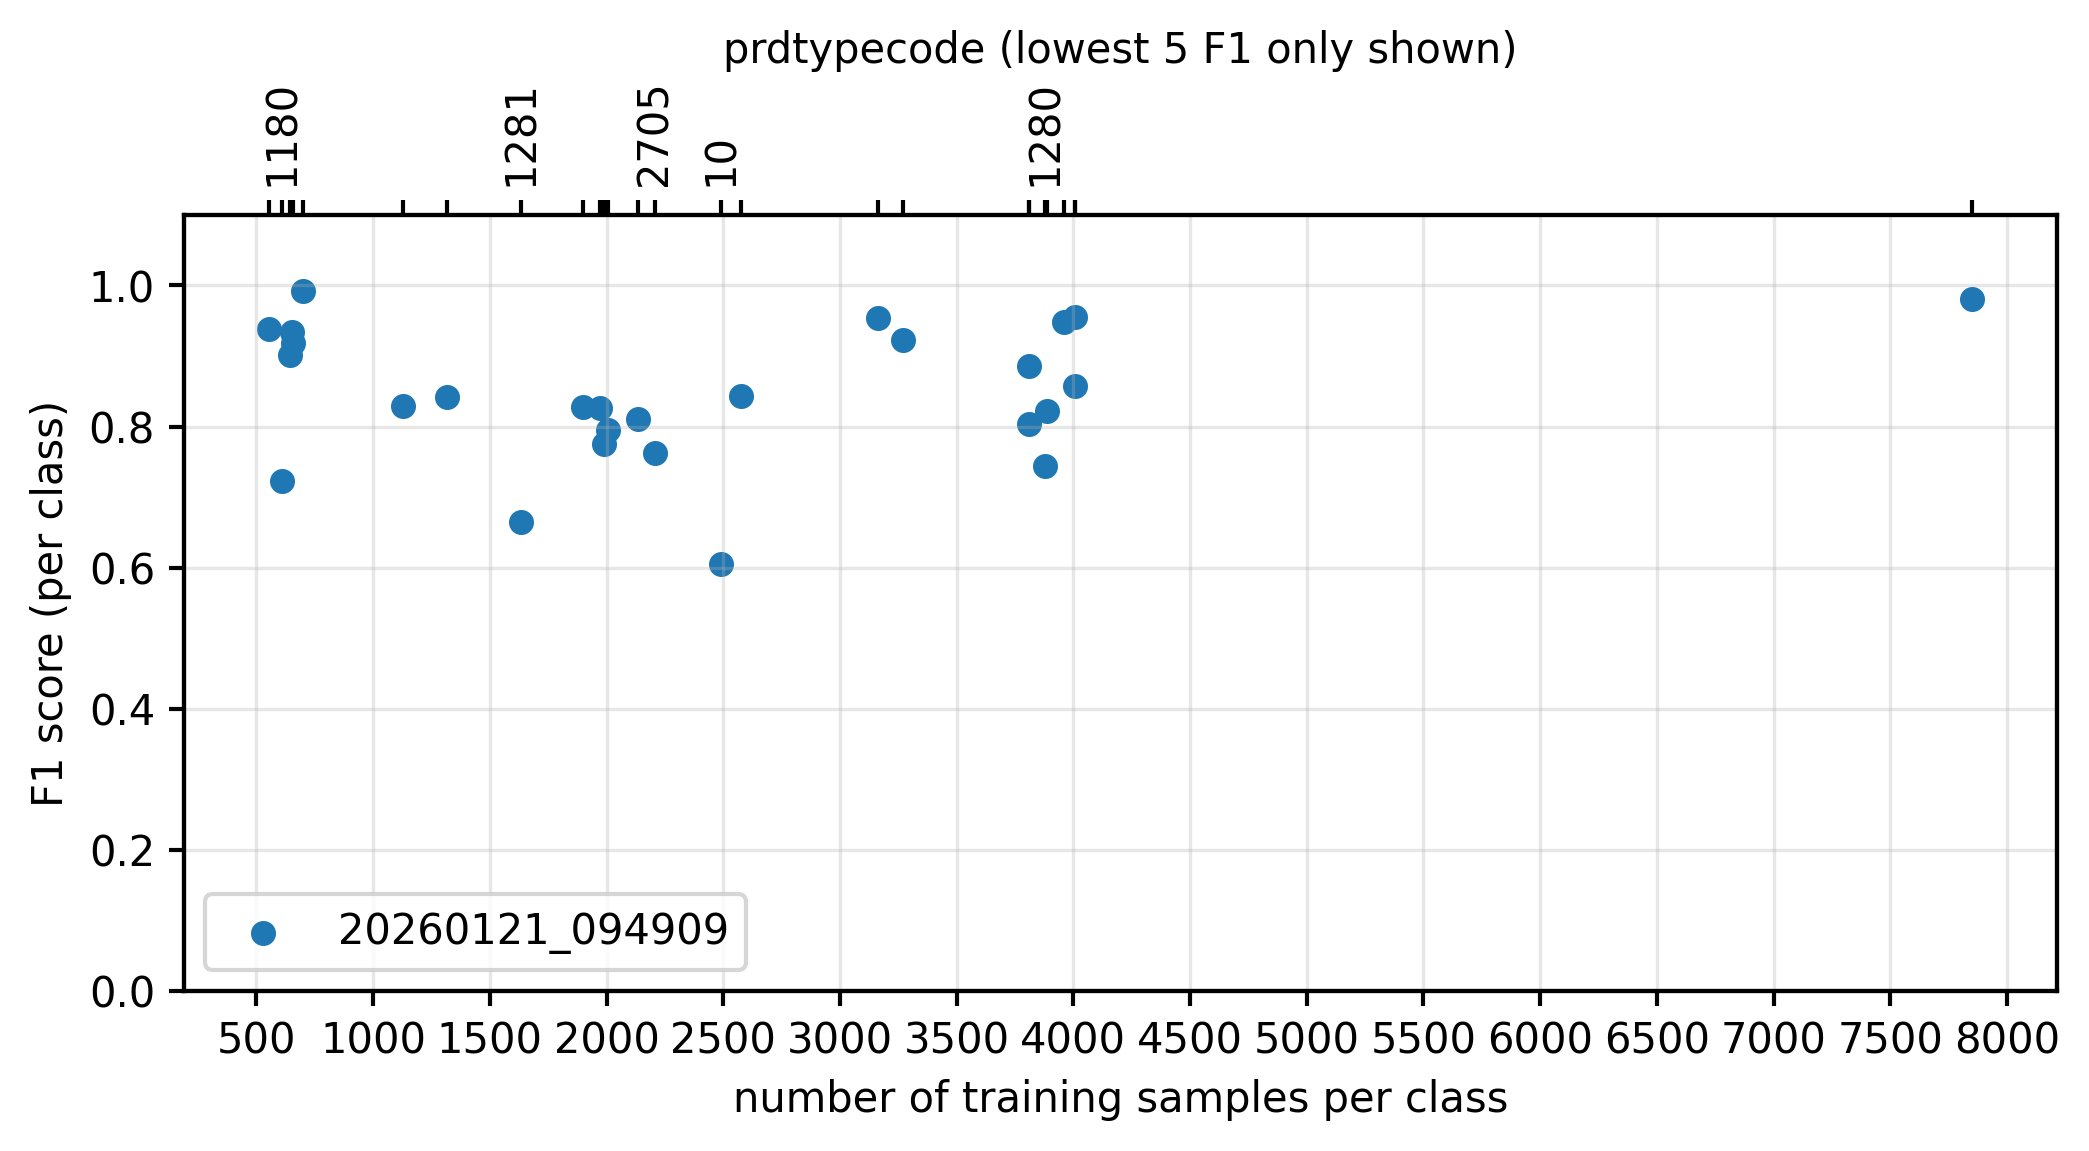

In [170]:
plot_f1_vs_class_and_ntrain(
    experiment_ids=["20260121_094909"])

20260120_215021
20260120_215110
20260120_215200
20260120_215253
20260120_215335
20260120_215424
20260120_215512
20260120_215600
20260120_220010
20260120_220451
20260120_220732
20260120_221036
20260120_221353
[20000, 50000, 80000, 120000, 150000, 200000]
{'experiment_id': '20260121_095512', 'text_column': 'text_stripped', 'label_column': 'prdtypecode', 'word_analyzer': 'word', 'word_ngram_min': 1, 'word_ngram_max': 2, 'word_max_features': 200000, 'word_min_df': 2, 'word_sublinear_tf': True, 'char_analyzer': 'char', 'char_ngram_min': 3, 'char_ngram_max': 5, 'char_max_features': 300000, 'char_min_df': 3, 'char_sublinear_tf': True, 'model': 'LinearSVC', 'class_weight': 'balanced', 'C': 5, 'run_name': 'TF-IDF Word+Char ngram combined C=5'}
char + word: max_features=500000, macro_f1=0.8451312534559438


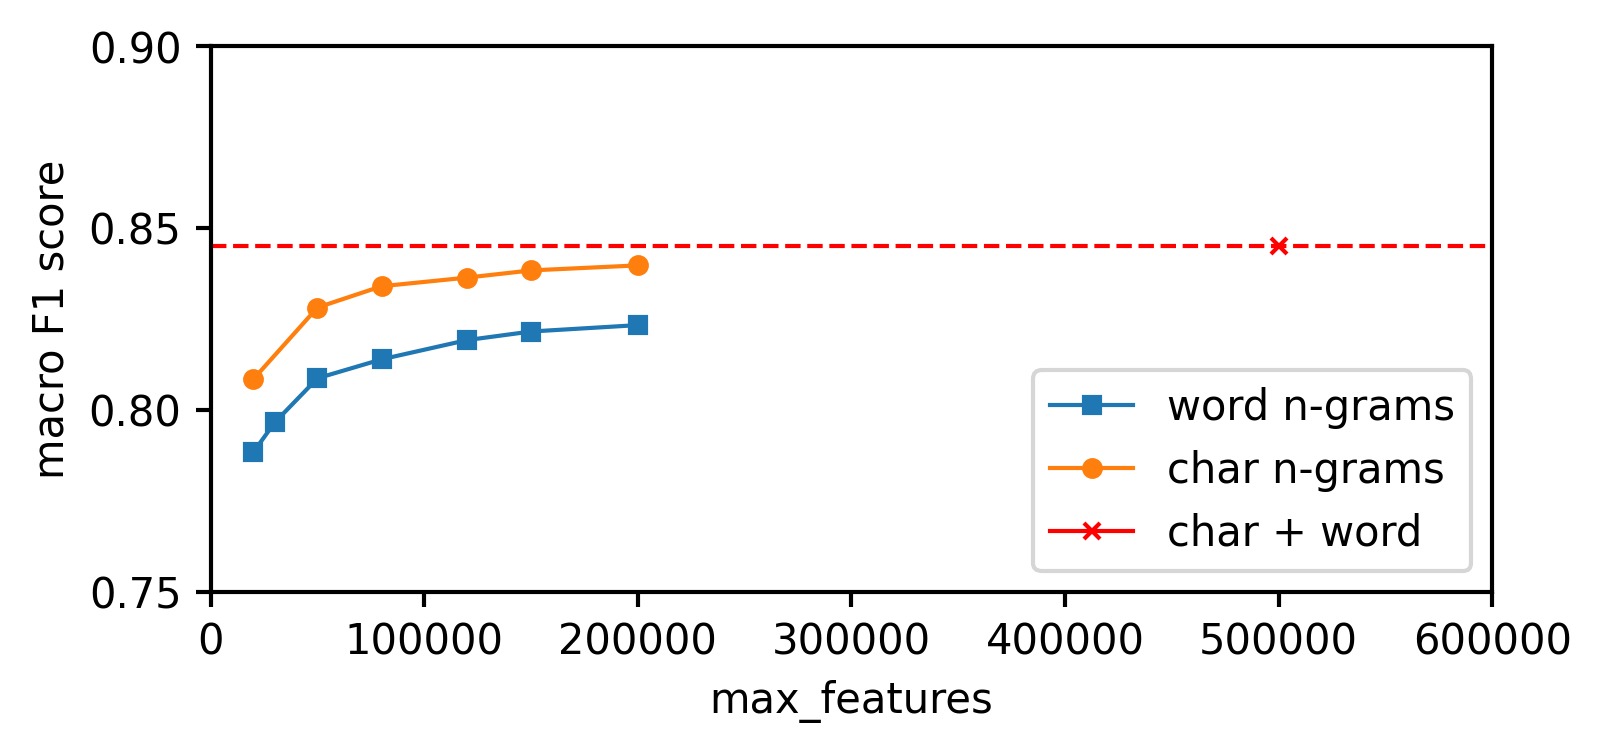

In [ ]:
# plot macro-f1 vs max_features for char
PATH = "experiments/LinSVM/"

experiments = ["20260120_215021",
                "20260120_215110",
                "20260120_215200",
                "20260120_215253",
                "20260120_215335",
                "20260120_215424",
                "20260120_215512",
]
macro_f1s = []
max_features = []
for experiment_id in experiments:
    print(experiment_id)
    dfm_exp = dfm[dfm["experiment_id"] == str(experiment_id)]
    macro_f1 = dfm_exp["f1"].mean()
    macro_f1s.append(macro_f1)
    CFG = joblib.load(f"{PATH}{experiment_id}/config.joblib")
    
    max_features.append(CFG.get("max_features", None))
    
# same for char max features

experiments = ["20260120_215600",
"20260120_220010",
"20260120_220451",
"20260120_220732",
"20260120_221036",
"20260120_221353"]

macro_f1s_char = []
max_features_char = []
for experiment_id in experiments:
    print(experiment_id)
    dfm_exp = dfm[dfm["experiment_id"] == str(experiment_id)]
    macro_f1 = dfm_exp["f1"].mean()
    CFG = joblib.load(f"{PATH}{experiment_id}/config.joblib")
    macro_f1s_char.append(macro_f1)
    max_features_char.append(CFG.get("max_features", None))

print(max_features_char)
plt.figure(figsize=(14*cm, 6*cm))
plt.plot(max_features, macro_f1s, marker='s', label='word n-grams')
plt.plot(max_features_char, macro_f1s_char, marker='o', label='char n-grams')
plt.ylim(0.75,0.9)
plt.xlim(0, 600e3)
plt.xlabel('max_features')
plt.ylabel('macro F1 score')


# add the point of one additional experiment
experiment_id = "20260121_095512"
dfm_exp = dfm[dfm["experiment_id"] == str(experiment_id)]
macro_f1 = dfm_exp["f1"].mean()
CFG = joblib.load(f"{PATH}{experiment_id}/config.joblib")
print(CFG)
max_feat = CFG.get("char_max_features") + CFG.get("word_max_features")
print(f"char + word: max_features={max_feat}, macro_f1={macro_f1}")
plt.plot(max_feat, macro_f1, marker='x', color='red', label='char + word')
# horizontal line at y=macro_f1
plt.axhline(y=macro_f1, color='red', linestyle='--')
plt.legend()

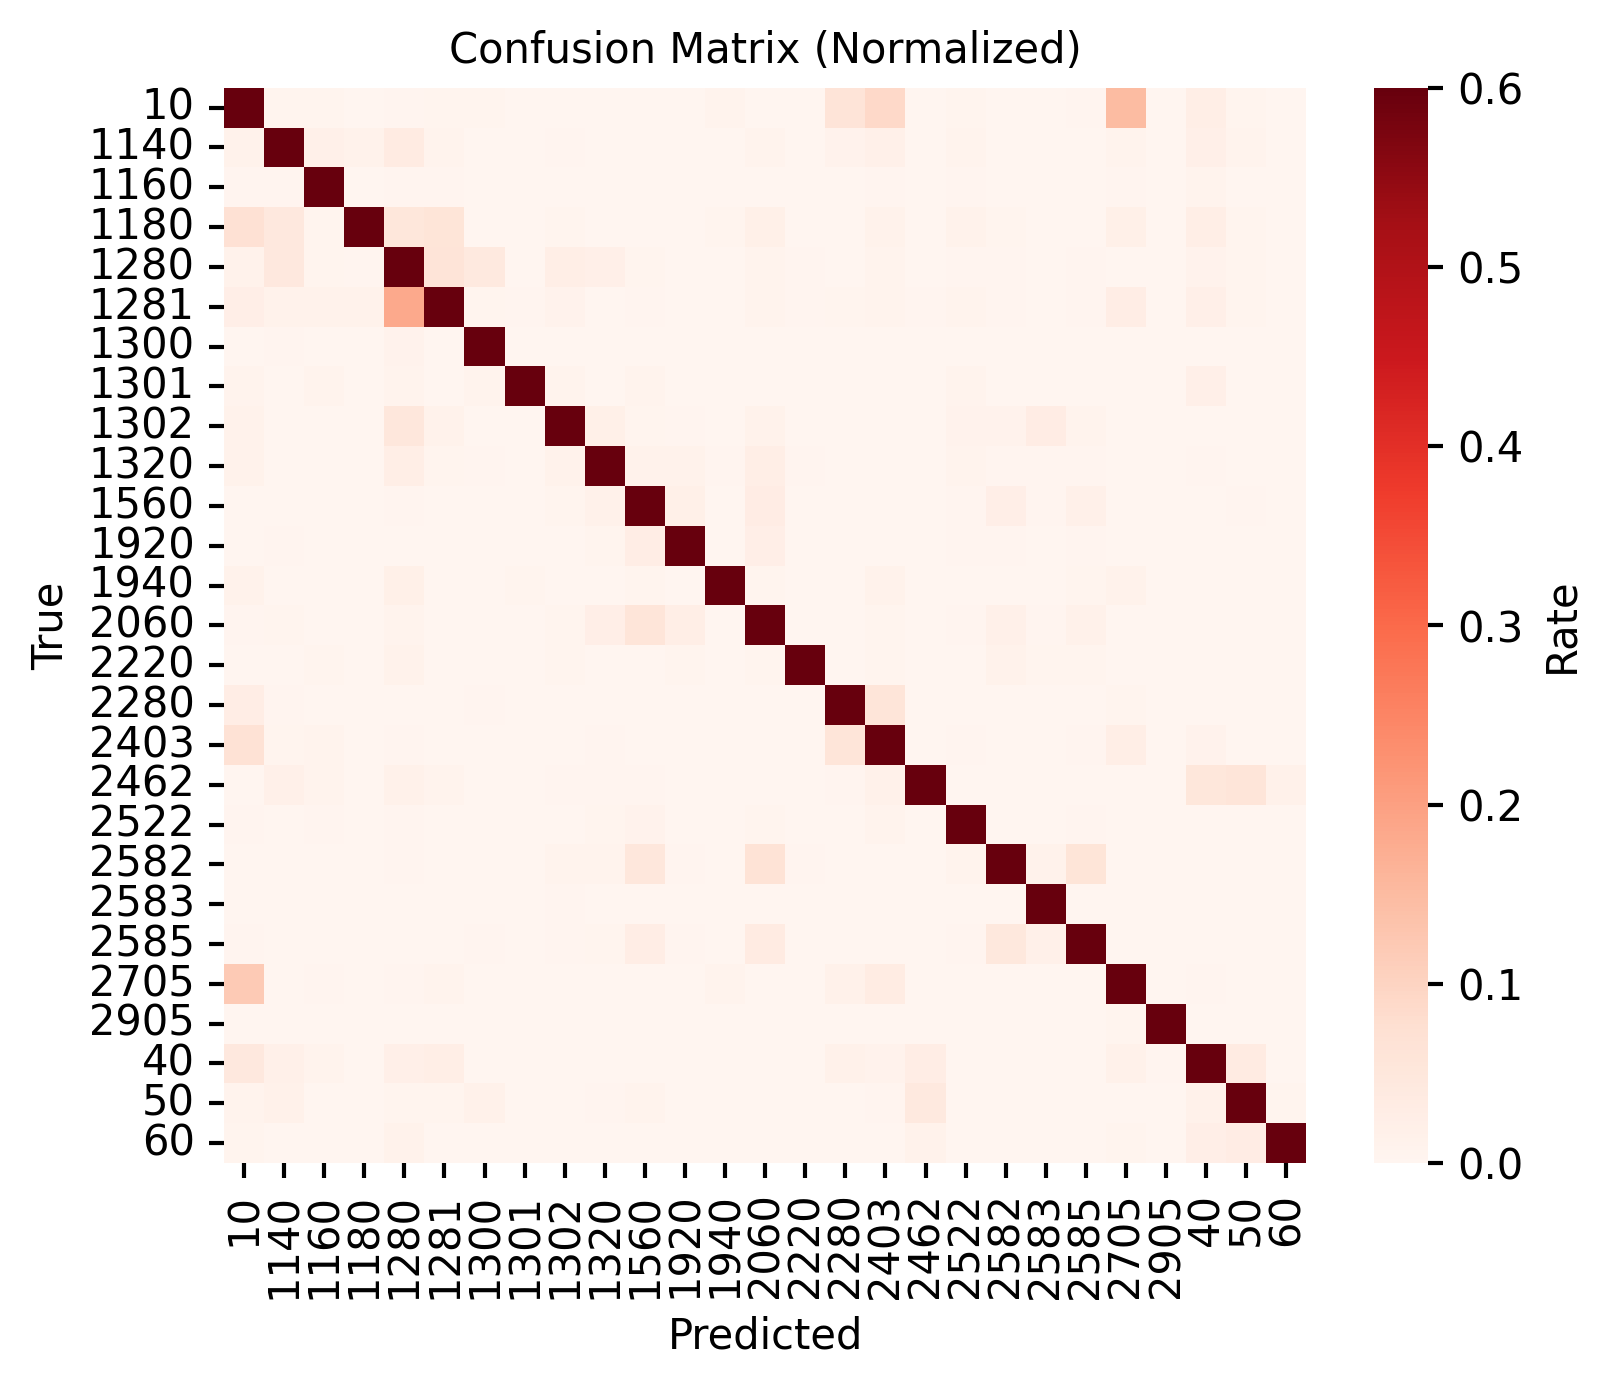

In [ ]:
experiment_id = "20260121_094909"
cm_raw = np.load(EXPERIMENTS_DIR / experiment_id / "confusion_raw.npy")
cm_norm = np.load(EXPERIMENTS_DIR / experiment_id / "confusion_norm.npy")
labels_sorted = np.sort(np.unique(y_val))
cm =
    plt.figure(figsize=(14*cm, 12*cm))
    sns.heatmap(cm_norm, fmt='.2f', cmap="Reds", 
                xticklabels=labels_sorted, 
                yticklabels=labels_sorted,
                cbar_kws={'label': 'Rate'},
                vmin=0, vmax=0.6)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix (Normalized)")
    plt.tight_layout()
    plt.show()

In [145]:
# table with five lowest f1 classes, add precision and recall
experiment_id = "20260121_095512"

dfm = pd.read_csv(METRICS_PATH)
dfm_worst = (
    dfm[dfm["experiment_id"] == experiment_id]
    .sort_values("f1")
    .head(5)
)

print("Five classes with lowest F1:")
print(dfm_worst[["class_id", "f1", "precision", "recall", "n_train_class", "support_val"]])




Five classes with lowest F1:
     class_id        f1  precision    recall  n_train_class  support_val
729        10  0.604909   0.596875  0.613162           2491          623
734      1281  0.653992   0.677165  0.632353           1632          408
732      1180  0.710623   0.808333  0.633987            611          153
733      1280  0.740897   0.758919  0.723711           3878          970
751      2705  0.768166   0.735099  0.804348           2207          552


In [173]:
# look which other classes these worst classes are confused with the most
worst_class_ids = dfm_worst["class_id"].astype(int).tolist()
print("Worst class IDs:", worst_class_ids)

for class_id in worst_class_ids:
    # Find the index of this class in the confusion matrix
    class_idx = np.where(labels_sorted.astype(int) == class_id)[0][0]
    
    # Get the row for this class (how it got classified)
    confusion_row = cm_norm[class_idx, :]
    
    # Get top 5 confused classes (excluding itself)
    top_indices = np.argsort(confusion_row)[::-1]
    
    print(f"\nClass {class_id} (F1={dfm_worst[dfm_worst['class_id']==class_id]['f1'].values[0]:.3f}):")
    print(f"  True class rate: {confusion_row[class_idx]:.2%}")
    
    count = 0
    for idx in top_indices:
        if count >= 2:  # Show top 5 confusions
            break
        confused_class = int(labels_sorted[idx])
        if confused_class != class_id:  # Skip the diagonal
            rate = confusion_row[idx]
            print(f"  → Confused with class {confused_class}: {rate:.2%}")
            count += 1

Worst class IDs: [10, 1281, 1180, 1280, 2705]

Class 10 (F1=0.605):
  True class rate: 61.64%
  → Confused with class 2705: 14.77%
  → Confused with class 2403: 8.99%

Class 1281 (F1=0.654):
  True class rate: 64.22%
  → Confused with class 1280: 18.38%
  → Confused with class 2705: 2.94%

Class 1180 (F1=0.711):
  True class rate: 64.71%
  → Confused with class 10: 7.19%
  → Confused with class 1281: 5.88%

Class 1280 (F1=0.741):
  True class rate: 71.86%
  → Confused with class 1281: 6.19%
  → Confused with class 1140: 4.54%

Class 2705 (F1=0.768):
  True class rate: 79.71%
  → Confused with class 10: 11.96%
  → Confused with class 2403: 3.44%
